In [ ]:
!pip install dash
!pip install plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# 📊 Sales Demand Forecasting Dashboard

This notebook demonstrates data preprocessing, feature engineering, demand forecasting using XGBoost, and an interactive dashboard built with Dash to visualize historical demand and forecast future sales trends.


In [ ]:

import pandas as pd
import numpy as np
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler # Import StandardScaler

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import mlflow
import mlflow.sklearn

### Load the dataset

In [ ]:

# Update path as needed
# file_path = "Historical Product Demand.csv"
file_path = "/content/drive/MyDrive/Colab/Historical Product Demand.csv"

data = pd.read_csv(file_path)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab/Historical Product Demand.csv'

## 🔍 Data Exploration

> In this section, we perform an initial exploration of the dataset. This includes checking its shape, summary statistics, data types, and missing values. This helps us understand the dataset's structure and identify potential issues.

In [ ]:
# Check the number of rows and columns
print(f'--------------------------\nData Shape\n--------------------------\n{data.shape}\n\n')

# Summary statistics for numerical columns
print(f"--------------------------\nStatistics\n--------------------------\n{data.describe()}\n\n")

# Info about data types and non-null counts
print(f'--------------------------\nInfo about the columns\n--------------------------')
print(data.info())
print('\n\n')
# Check for missing values
print(f'--------------------------\nMissing Values\n--------------------------\n{data.isnull().sum()}\n\n')

# unique values in each column
print(f'--------------------------\nUnique Values\n--------------------------')

for col in data.columns:
  print(f"'{col}': {data[col].nunique()} unique values")
print('\n\n')
# Display info again to confirm any updates
print(f'--------------------------\nInfo about the columns\n--------------------------')
print(data.info())
print('\n\n')

--------------------------
Data Shape
--------------------------
(21128, 5)


--------------------------
Statistics
--------------------------
       Order_Demand
count  2.112700e+04
mean   1.453929e+04
std    6.273185e+04
min    1.000000e+00
25%    2.000000e+02
50%    2.000000e+03
75%    1.000000e+04
max    4.000000e+06


--------------------------
Info about the columns
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21128 entries, 0 to 21127
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_Code      21128 non-null  object 
 1   Warehouse         21128 non-null  object 
 2   Product_Category  21128 non-null  object 
 3   Date              21127 non-null  object 
 4   Order_Demand      21127 non-null  float64
dtypes: float64(1), object(4)
memory usage: 825.4+ KB
None



--------------------------
Missing Values
--------------------------
Product_Code        0
Warehous

### Clean and preprocess the data

In [ ]:

data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])
data['Order_Demand'] = data['Order_Demand'].astype(str).str.replace('[^0-9]', '', regex=True)
data['Order_Demand'] = pd.to_numeric(data['Order_Demand'], errors='coerce')
data = data.dropna(subset=['Order_Demand'])
data = data[data['Order_Demand'] > 0]


<ipython-input-9-0c2d772692e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Order_Demand'] = data['Order_Demand'].astype(str).str.replace('[^0-9]', '', regex=True)
<ipython-input-9-0c2d772692e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Order_Demand'] = pd.to_numeric(data['Order_Demand'], errors='coerce')


### Feature Engineering

In [ ]:
# Add new features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Weekday'] = data['Date'].dt.weekday

In [ ]:
# Lag and Rolling Features
for lag in [1, 7, 30]:
    data[f'Lag_{lag}'] = data['Order_Demand'].shift(lag)
for window in [7, 30]:
    data[f'Rolling_{window}'] = data['Order_Demand'].rolling(window=window).mean()

In [ ]:
# External Factors (simulated for demo purposes)
np.random.seed(42)
data['Weather_Index'] = np.random.normal(loc=0.5, scale=0.1, size=len(data))  # 0 to 1 index
promotions = np.random.choice([0, 1], size=len(data), p=[0.8, 0.2])  # 20% chance of promotion
data['Promotion'] = promotions
data['Econ_Indicator'] = np.random.normal(loc=0.6, scale=0.15, size=len(data))

In [ ]:
data.head(5)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Day,Weekday,Lag_1,Lag_7,Lag_30,Rolling_7,Rolling_30,Weather_Index,Promotion,Econ_Indicator
0,Product_0993,Whse_J,Category_028,2012-07-27,1000,2012,7,27,4,NaN,NaN,NaN,NaN,NaN,0.549671,0,0.473740
1,Product_0979,Whse_J,Category_028,2012-01-19,5000,2012,1,19,3,1000.0,NaN,NaN,NaN,NaN,0.486174,0,0.489838
2,Product_0979,Whse_J,Category_028,2012-02-03,5000,2012,2,3,4,5000.0,NaN,NaN,NaN,NaN,0.564769,0,0.494260
3,Product_0979,Whse_J,Category_028,2012-02-09,5000,2012,2,9,3,5000.0,NaN,NaN,NaN,NaN,0.652303,0,0.505803
4,Product_0979,Whse_J,Category_028,2012-03-02,5000,2012,3,2,4,5000.0,NaN,NaN,NaN,NaN,0.476585,1,0.556447


In [ ]:
# Drop NA from feature generation
data = data.dropna()

In [ ]:
#  Prepare Features and Target
features = ['Year', 'Month', 'Day', 'Weekday',
            'Lag_1', 'Lag_7', 'Lag_30',
            'Rolling_7', 'Rolling_30',
            'Weather_Index', 'Promotion', 'Econ_Indicator']
X = data[features]
y = data['Order_Demand']

In [ ]:

#  Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time Series Analysis

<ipython-input-17-8ac3bd6487f8>:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


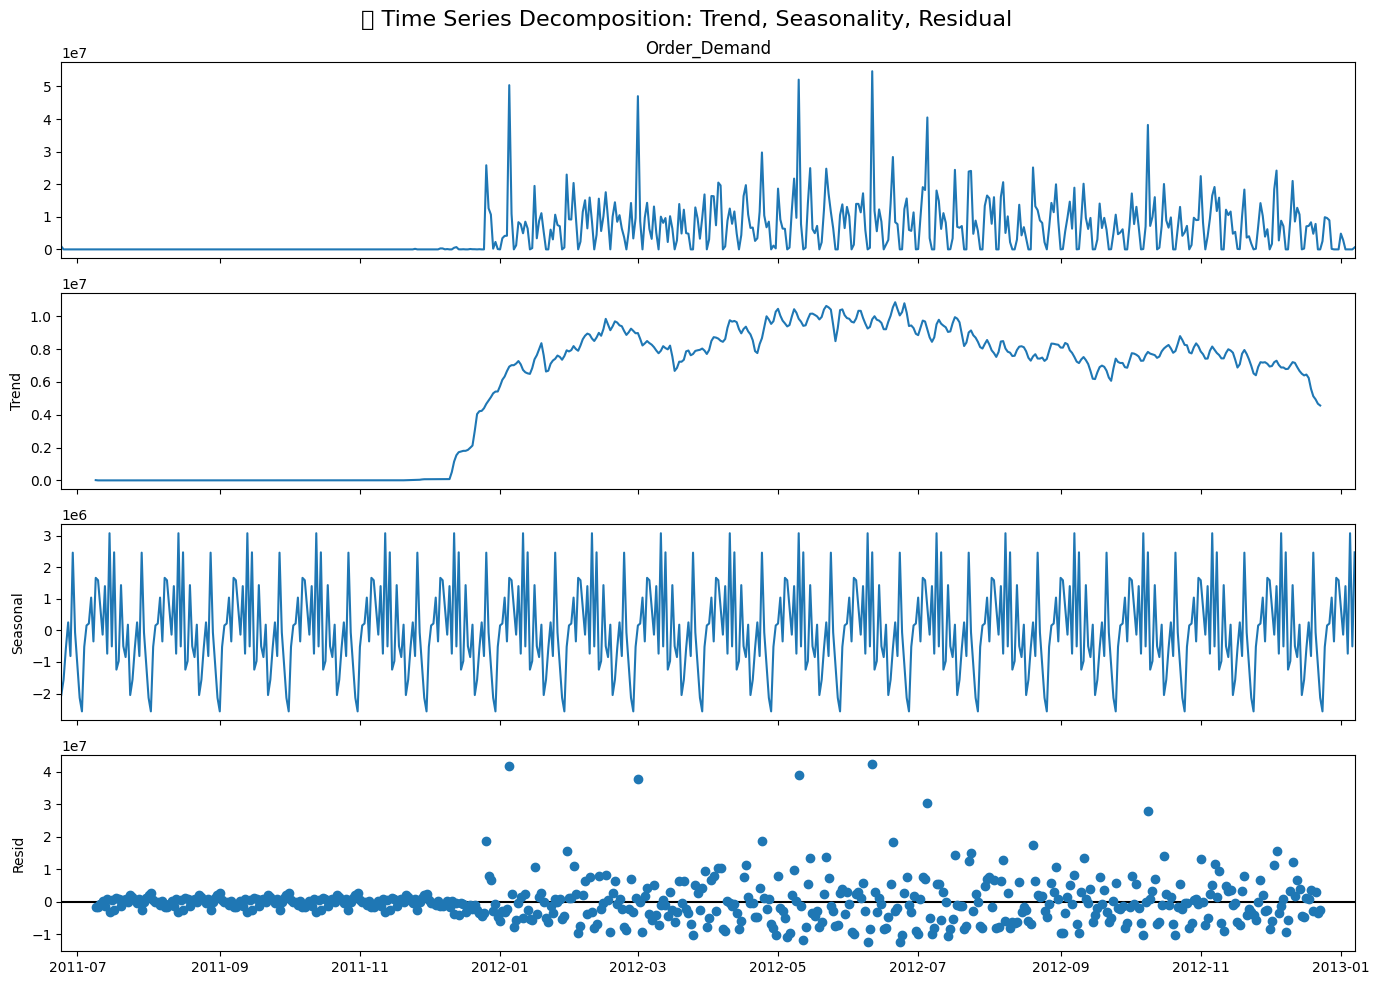

In [ ]:
# Aggregate demand by date (daily level)
daily_demand = data.groupby('Date')['Order_Demand'].sum()

# Use a monthly frequency since this is typical for demand patterns`
decomposition = seasonal_decompose(daily_demand.resample('D').sum(), model='additive', period=30)

# Plot decomposition
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle("📊 Time Series Decomposition: Trend, Seasonality, Residual", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:

#  ADF Test for stationarity
adf_result = adfuller(daily_demand.dropna())
adf_output = {
    "ADF Statistic": adf_result[0],
    "p-value": adf_result[1],
    "Used Lag": adf_result[2],
    "Number of Observations Used": adf_result[3],
    "Critical Values": adf_result[4],
    "Stationary": adf_result[1] < 0.05
}

adf_output

{'ADF Statistic': np.float64(-6.7382179917208065),
 'p-value': np.float64(3.1674089929763263e-09),
 'Used Lag': 5,
 'Number of Observations Used': 328,
 'Critical Values': {'1%': np.float64(-3.4504451681828194),
  '5%': np.float64(-2.870392380216117),
  '10%': np.float64(-2.571486353732897)},
 'Stationary': np.True_}

### Train XGBoost model

In [ ]:
# Group the data and prepare features
data_grouped = data.groupby(['Year', 'Month'])['Order_Demand'].sum().reset_index()
X_scaled = data_grouped[['Year', 'Month']]
y = data_grouped['Order_Demand']

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# MLflow tracking
with mlflow.start_run(run_name="Manual XGBoost Model"):
    model = XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    threshold = 0.1 * y_test.mean()
    success_rate = (abs(y_test - y_pred) <= threshold).mean() * 100

    # Log parameters, metrics, and model
    mlflow.log_param("n_estimators", 100)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2_score", r2)
    mlflow.log_metric("success_rate", success_rate)
    mlflow.xgboost.log_model(model, "model")

    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print(f"Success Rate: {success_rate:.2f}%")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:06:10] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/04/11 19:06:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RMSE: 23026133.14
R²: 0.96
Success Rate: 50.00%


### Hyperparameter Tuning

In [ ]:
# prompt: use grid search on the XGBoost model for hyperparameter tuning and show RMSE, R2, success rate

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearch
model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=TimeSeriesSplit(n_splits=5), verbose=1)

# MLflow tracking
with mlflow.start_run(run_name="GridSearchCV XGBoost Model"):
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    threshold = 0.1 * y_test.mean()
    success_rate = (abs(y_test - y_pred) <= threshold).mean() * 100

    # Log best params and metrics
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2_score", r2)
    mlflow.log_metric("success_rate", success_rate)
    mlflow.xgboost.log_model(best_model, "model")

    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print(f"Success Rate: {success_rate:.2f}%")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:13] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/04/11 19:07:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
RMSE: 83236847.65
R²: 0.44
Success Rate: 0.00%


In [ ]:
#To Run MLflow UI Locally:
!mlflow ui

[2025-04-11 18:49:01 +0000] [2265] [INFO] Starting gunicorn 23.0.0
[2025-04-11 18:49:01 +0000] [2265] [INFO] Listening at: http://127.0.0.1:5000 (2265)
[2025-04-11 18:49:01 +0000] [2265] [INFO] Using worker: sync
[2025-04-11 18:49:01 +0000] [2266] [INFO] Booting worker with pid: 2266
[2025-04-11 18:49:01 +0000] [2267] [INFO] Booting worker with pid: 2267
[2025-04-11 18:49:01 +0000] [2268] [INFO] Booting worker with pid: 2268
[2025-04-11 18:49:02 +0000] [2269] [INFO] Booting worker with pid: 2269
[2025-04-11 18:54:55 +0000] [2265] [INFO] Handling signal: int

Aborted!
[2025-04-11 18:54:55 +0000] [2267] [INFO] Worker exiting (pid: 2267)
[2025-04-11 18:54:55 +0000] [2268] [INFO] Worker exiting (pid: 2268)
[2025-04-11 18:54:55 +0000] [2269] [INFO] Worker exiting (pid: 2269)
[2025-04-11 18:54:55 +0000] [2266] [INFO] Worker exiting (pid: 2266)
[2025-04-11 18:54:57 +0000] [2265] [INFO] Shutting down: Master


# Model Deployment

In [ ]:
import joblib

# Save the trained model
joblib.dump(best_model, "xgb_demand_model.pkl")


['xgb_demand_model.pkl']

### Forecast the next 6 months

In [ ]:

last_date = data['Date'].max()
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=6, freq='MS')
future_data = pd.DataFrame({
    'Year': future_dates.year,
    'Month': future_dates.month})
# Load the saved XGBoost model
model = joblib.load("xgb_demand_model.pkl")

future_data['Predicted_Order_Demand'] = model.predict(future_data[['Year', 'Month']])
print(future_data)

   Year  Month  Predicted_Order_Demand
0  2013      2             125495128.0
1  2013      3             125495128.0
2  2013      4             125495128.0
3  2013      5             125495128.0
4  2013      6             125495128.0
5  2013      7             125495128.0


# Random Forest

In [ ]:
# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Predict
y_pred = model.predict(X_test)
# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
# Custom success rate
threshold = 0.1 * y_test.mean()
success_rate = (abs(y_test - y_pred) <= threshold).mean() * 100
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"Custom Success Rate (Within {threshold:.2f}): {success_rate:.2f}%")


MAE: 6047063.66
RMSE: 7314846.08
R²: 0.96
Custom Success Rate (Within 6864146.92): 64.29%


# MLOps Implementation with XGBoost

In [ ]:
import xgboost as xgb

def train_model(X, y):
    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X, y)
    return model


MODEL DEPLOYMENT (Flask API for Model Inference)

*   List item
*   List item



In [ ]:
# @title Default title text

from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)
model = joblib.load("xgb_demand_model.pkl")

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    prediction = model.predict([data['features']])
    return jsonify({'prediction': prediction.tolist()})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:

# ====================== Forecast the next 6 months ======================
future_dates = pd.DataFrame({'Year': [2024]*6, 'Month': list(range(1, 7))})
future_predictions = model.predict(future_dates)

# ====================== Dash App ======================
app = dash.Dash(__name__)
app.title = "Sales Demand Dashboard"

app.layout = html.Div([
    html.H1("📊 Sales Demand Analysis Dashboard", style={'textAlign': 'center'}),

    dcc.Dropdown(
        id='product-dropdown',
        options=[{'label': p, 'value': p} for p in sorted(data['Product_Code'].unique())],
        placeholder="🔍 Select a Product",
        style={'width': '50%', 'margin': 'auto'}
    ),

    html.Div([
        dcc.Graph(id='demand-trend'),
        dcc.Graph(id='actual-vs-predicted'),
        dcc.Graph(id='monthly-demand'),
        dcc.Graph(id='yearly-demand'),
        dcc.Graph(id='correlation-heatmap'),
        dcc.Graph(id='bar-warehouse'),
        dcc.Graph(id='box-category'),
        dcc.Graph(id='pie-warehouse')
    ], style={'display': 'flex', 'flexWrap': 'wrap', 'justifyContent': 'space-around'}),

    html.Div([
        html.H3(f"RMSE: {rmse:.4f}", style={'textAlign': 'center'}),
        html.H3(f"R²: {r2:.4f}", style={'textAlign': 'center'})
    ], style={'marginTop': '20px'}),

    html.Div([
        html.H3("📅 Future Forecast for 2024", style={'textAlign': 'center'}),
        html.Table([
            html.Tr([html.Th("Month"), html.Th("Predicted Demand")])] +
            [html.Tr([html.Td(str(month)), html.Td(f"{pred:.2f}")])
             for month, pred in zip(future_dates['Month'], future_predictions)]
        )
    ], style={'textAlign': 'center', 'marginTop': '30px'})
])

# ====================== Callback ======================
@app.callback(
    [Output('demand-trend', 'figure'),
     Output('actual-vs-predicted', 'figure'),
     Output('monthly-demand', 'figure'),
     Output('yearly-demand', 'figure'),
     Output('correlation-heatmap', 'figure'),
     Output('bar-warehouse', 'figure'),
     Output('box-category', 'figure'),
     Output('pie-warehouse', 'figure')],
    [Input('product-dropdown', 'value')]
)
def update_graphs(product):
    try:
        # Filter data
        filtered_df = data[data['Product_Code'] == product].copy() if product else data.copy()

        if filtered_df.empty:
            return [{}]*8

        # Ensure correct columns for prediction
        if 'Year' not in filtered_df or 'Month' not in filtered_df:
            raise ValueError("Missing 'Year' or 'Month' column for prediction")

        # Predict
        filtered_df['Predicted_Demand'] = model.predict(filtered_df[['Year', 'Month']])

        # Plots
        fig_trend = px.line(filtered_df, x='Date', y='Order_Demand', title='📈 Demand Over Time')

        fig_predicted = px.line(filtered_df, x='Date', y=['Order_Demand', 'Predicted_Demand'],
                                title='🤖 Actual vs Predicted Demand')

        fig_monthly = px.bar(filtered_df.groupby('Month', as_index=False)['Order_Demand'].sum(),
                             x='Month', y='Order_Demand', title='📅 Total Demand by Month')

        fig_yearly = px.bar(filtered_df.groupby('Year', as_index=False)['Order_Demand'].sum(),
                            x='Year', y='Order_Demand', title='📆 Total Demand by Year')

        corr_fig = px.imshow(filtered_df.corr(numeric_only=True), title="Correlation Heatmap")

        warehouse_demand = filtered_df.groupby('Warehouse')['Order_Demand'].sum().reset_index()
        bar_warehouse_fig = px.bar(warehouse_demand, x='Warehouse', y='Order_Demand', title="Order Demand by Warehouse")

        box_category_fig = px.box(filtered_df, x='Product_Category', y='Order_Demand',
                                  title="Demand by Product Category")

        pie_warehouse_fig = px.pie(warehouse_demand, names='Warehouse', values='Order_Demand',
                                   title="Demand Distribution by Warehouse")

        return (fig_trend, fig_predicted, fig_monthly, fig_yearly,
                corr_fig, bar_warehouse_fig, box_category_fig, pie_warehouse_fig)

    except Exception as e:
        print(f"Error in callback: {e}")
        return [{}]*8

# ====================== Run ======================
if __name__ == '__main__':
    app.run(debug=True)

<IPython.core.display.Javascript object>

### **Interactive dashboard**

# Model **Monitoring**

In [ ]:
import numpy as np

def monitor_model(preds, actuals, threshold=1000):
    error = np.abs(actuals - preds)
    if error.mean() > threshold:
        send_alert("⚠️ Model performance degraded")


# Model retraining strategy

In [ ]:
from datetime import datetime

def should_retrain(new_data_date):
    return (datetime.now() - new_data_date).days > 30
